# **Este *ipynb* está enmarcado dentro de un trabajo que busca predecir qué alumnos del departamento de Sistemas la UTN FRBA desertarán.**

Los datos disponibles fueron unificados en una sola tabla y se removieron los registros con valores nulos.

Se utilizarán herramientas del aprendizaje estadístico para crear un modelo supervisado de **REDES NEURONALES** que prediga el outcome de la variable 'deserto'.

## **Fuente**

Para la construcción del modelo de Redes Neuronales se utilizó como referencia el código de la siguente fuente:
* https://github.com/clusterai/clusterai_2022/blob/main/clase09/clusterai2022_clase09_Redes_Neuronales_Clasificacion_TensorFlow.ipynb  - Nicolás Aguirre, **ClusterAI 2022** 

## **LIBRERÍAS**

In [133]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [258]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

## **Google Colaboratory o Local**
El notebook podrá ser corrido directamente tanto localmente como en Google Colaboratory.


In [136]:
## Verificamos si estamos corriendo el noteboock en Google Colaboratory.
var_google_colab = 'google.colab' in str(get_ipython())
print(var_google_colab)

## En el caso de estar en Google Colab, montamos nuestro Drive.
if var_google_colab:
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  ## Dirección root donde está el notebook.
  root_path = "/content/gdrive/MyDrive/Colab Notebooks/GIAR/"

## En el caso de no estar en Google Colab, estamos corriendo localmente el notebook.
else:
  root_path = ""

True
Mounted at /content/gdrive


## **DATASET**


In [137]:
## Importamos el dataset.
df = pd.read_csv(root_path + 'datos/base_datos_estudiantes_completo.csv')

In [138]:
## Imprimimos las dimensiones del dataset.
print(f'Dimensiones del dataset: {df.shape}')

Dimensiones del dataset: (3177, 30)


In [140]:
## Calculamos el Sample to Feature Ratio (S2FR) y lo imprimimos.
S2FR = df.shape[0] / (df.shape[1]-2)
S2FR

113.46428571428571

In [141]:
## Dividimos el dataset en la variable dependiente "y", en este caso "deserto", y las independientes "x".
y = np.array(df[["deserto"]])
x = df.drop(['Codigo Alumno','deserto'], axis=1)

In [142]:
x.shape

(3177, 28)

In [143]:
n_features = np.shape(x)[0]
n_samples = np.shape(x)[1]
n_classes = np.unique(y)
print(f'Features: ',n_samples)
print(f'Samples: ',n_features)
print(f'Classes: ',n_classes)

Features:  28
Samples:  3177
Classes:  [0 1]


In [145]:
## Diferenciamos las variables numéricas de las categóricas.
num_features = ['edad al ingreso',
                'Ciclo Lectivo de Cursada',
                'Distancia',
                'Cantidad de veces recursada regular',
                'Descripción de recursada regular_No Recurso', 
                'Descripción de recursada regular_Recurso 1 Vez', 
                'Descripción de recursada regular_Recurso 2 Veces', 
                'Descripción de recursada regular_Recurso 3 Veces', 
                'Descripción de recursada regular_Recurso 4 Veces', 
                'Descripción de recursada regular_Recurso 5 Veces',
                'noAprobado', 
                'Aprobado', 
                'Promociono', 
                'Nota', 
                'Nota_max_prom', 
                'Indice_aprobacion', 
                'Turno_Mañana', 
                'Turno_Noche', 
                'Turno_Tarde', 
                'Tipo de aprobación_Cambio Curso', 
                'Tipo de aprobación_Firmo', 
                'Tipo de aprobación_Libre', 
                'Tipo de aprobación_No Firmo', 
                'Tipo de aprobación_Promociono',
                'cantidad de años']

cat_features = ['EsTecnico', 'Sexo', 'grupo_ingreso_nivel1']

## **SPLIT**

In [147]:
## Separamos el dataset en train y test. Corresponderán a test el ...% de las muestras.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.216, random_state=4)

In [148]:
x_train.shape

(2490, 28)

In [149]:
x_test.shape

(687, 28)

In [150]:
pd.DataFrame(y_train).value_counts()

0    1512
1     978
dtype: int64

In [151]:
## Utilizamos la técnica de oversampling para balancear los datos de train.
oversample = RandomOverSampler(sampling_strategy='minority')

xtrain_over, ytrain_over = oversample.fit_resample(x_train, y_train)

In [152]:
xtrain_over.shape

(3024, 28)

In [153]:
pd.DataFrame(ytrain_over).value_counts()

0    1512
1    1512
dtype: int64

##**ESTANDARIZACIÓN**

In [154]:
## Definimos las transformaciones a realizar para las variables numéricas. 
## Las estandarizaremos utilizando StandardScaler.
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

## Definimos la transformación a realizar para las variables categóricas.
do_nothing = FunctionTransformer(lambda x: x)

## Definimos el ColumnTransformer que será ejecutado al momento del fitting.
preprocesamiento = ColumnTransformer(
    transformers=[ 
        ("num", numeric_transformer, num_features),
        ("cat", do_nothing, cat_features)
    ]
)

In [155]:
## Estandarizamos el set de train.
x_train_norm = pd.DataFrame(preprocesamiento.fit_transform(xtrain_over))

In [156]:
x_test_norm = pd.DataFrame(preprocesamiento.fit_transform(x_test))

In [157]:
x_train_norm.head() 

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.150682,0.559187,-0.542577,1.678485,0.474525,2.024699,-0.639635,-0.354198,-0.232834,5.991652,...,1.197177,-0.580018,0.736601,-0.120483,1.546820,0.564453,1.411155,1.0,0.0,27.0
1,-0.210289,0.559187,0.918085,-0.296318,-0.739674,0.450743,-0.639635,-0.354198,-0.232834,-0.141982,...,-0.734660,-0.186926,-0.372592,-0.935560,-0.267427,-0.461640,-0.791339,0.0,0.0,108.0
2,-0.210289,0.559187,-0.542577,-1.036870,0.253761,-1.123213,-0.639635,-0.354198,-0.232834,-0.141982,...,-0.976140,-0.580018,0.071085,-0.935560,-1.401332,1.077499,-0.791339,1.0,0.0,103.0
3,-0.210289,0.559187,0.631504,1.678485,-0.850056,-0.598561,1.563391,3.781308,-0.232834,-0.141982,...,0.714218,2.171621,-0.483511,0.966287,1.773601,-0.461640,0.309908,0.0,0.0,61.0
4,-0.210289,0.559187,-0.542577,-0.543169,-0.187766,-0.073909,-0.639635,-0.354198,-0.232834,-0.141982,...,-0.976140,-0.580018,-0.039834,-0.935560,-0.267427,0.051406,-0.791339,0.0,0.0,99.0


#**Pruebo un modelo**

## **MODELO**

In [366]:
# Para eliminar los modelos que hayan quedado guardados en memoria
tf.keras.backend.clear_session() 

model = Sequential([
  # Primera capa de la red
  Dense(16,input_dim=28, activation='sigmoid'),
  # Hidden Layers
  Dense(16, activation='sigmoid'),
  # Salida de la red
  Dense(1, activation='sigmoid')
])

In [367]:
#Veamos la arquitectura de nuestro modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


## **Optimizador & Función de Penalización**

In [368]:
# Optimizador
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate = lr)
# Funcion de penalizacion Error Cuadrático Medio
loss_func = tf.keras.losses.MeanSquaredError()

## **COMPILACIÓN DEL MODELO DE REDES NEURONALES**

In [369]:
# Hasta este momento, hemos definido los elementos que conformaran el modelo.
# [arquitectura, optimizer, loss function].
# Internamente, estuvimos armando un 'grafo computacional', el cual debe compilarse.
model.compile(optimizer = opt,
              loss = loss_func,
              metrics = ['accuracy'])

## **ENTRENAMIENTO**

In [370]:
# Batch Size
bs = 100
# Epochs de entrenamiento
epochs_training = 500
# Entrenamos!
training = model.fit(x_train_norm,ytrain_over, epochs=epochs_training, validation_split=0.2,batch_size=bs)

Epoch 1/500
25/25 [==============================] - 8s 37ms/step - loss: 0.2371 - accuracy: 0.6064 - val_loss: 0.3405 - val_accuracy: 0.0760
Epoch 2/500
25/25 [==============================] - 0s 11ms/step - loss: 0.2318 - accuracy: 0.6060 - val_loss: 0.3350 - val_accuracy: 0.0777
Epoch 3/500
25/25 [==============================] - 0s 8ms/step - loss: 0.2264 - accuracy: 0.6110 - val_loss: 0.3244 - val_accuracy: 0.1124
Epoch 4/500
25/25 [==============================] - 0s 12ms/step - loss: 0.2191 - accuracy: 0.6346 - val_loss: 0.3096 - val_accuracy: 0.1967
Epoch 5/500
25/25 [==============================] - 0s 14ms/step - loss: 0.2079 - accuracy: 0.6714 - val_loss: 0.2827 - val_accuracy: 0.3686
Epoch 6/500
25/25 [==============================] - 0s 13ms/step - loss: 0.1959 - accuracy: 0.7239 - val_loss: 0.2674 - val_accuracy: 0.4612
Epoch 7/500
25/25 [==============================] - 0s 6ms/step - loss: 0.1839 - accuracy: 0.7648 - val_loss: 0.2435 - val_accuracy: 0.5322
Epoch 8/

## **HISTORIAL**

El historial de entrenamiento queda guardado dentro de un diccionario en
training.history.

Deseamos ver como fue el progreso de neustro entrenamiento epochs por epoch en terminos de la loss_fuction y el accuracy.

Si al momento de compilar el modelo le pasamos mas metricas, quedaran guardadas tambien.

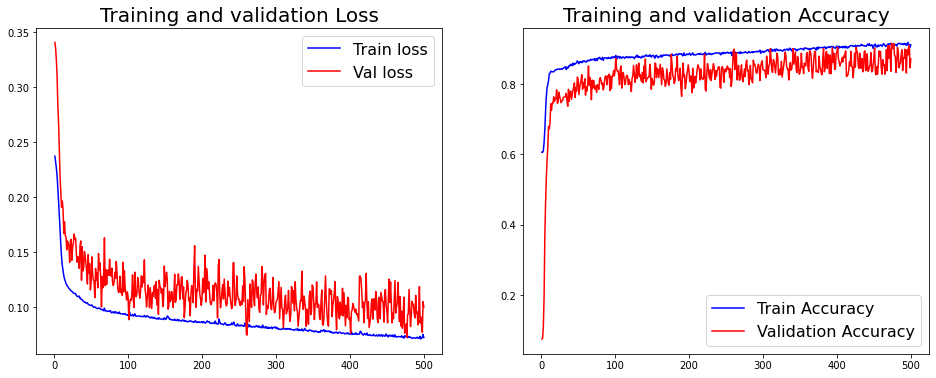

In [371]:
# El historial de entrenamiento quedó guardado en 
# 'history.history', ingresamos como 'key' cada una de las metricas que queremos plotear.

#Loss
loss_history = training.history['loss']
val_loss_hist = training.history['val_loss']

#Accuracy
train_acc_history = training.history['accuracy']
val_acc_hist = training.history['val_accuracy']
epochs = range(1, len(loss_history) + 1)

fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(epochs, loss_history, 'b', label='Train loss')
axs[0].plot(epochs, val_loss_hist, 'r', label='Val loss')
axs[0].set_title('Training and validation Loss',fontsize=20)
axs[0].legend(fontsize=16)
axs[1].plot(epochs, train_acc_history, 'b', label='Train Accuracy')
axs[1].plot(epochs, val_acc_hist, 'r', label='Validation Accuracy')
axs[1].set_title('Training and validation Accuracy',fontsize=20)
axs[1].legend(fontsize=16)
plt.show()

## **EVALUACIÓN**

In [372]:
## Evaluamos el modelo.
model.evaluate(x_test_norm, y_test,verbose=2)

22/22 - 1s - loss: 0.1244 - accuracy: 0.8282 - 673ms/epoch - 31ms/step


[0.12444022297859192, 0.8282387256622314]

## **MATRIZ DE CONFUSIÓN**

In [373]:
y_hat = model.predict(x_test_norm) # Salida de la red
y_pred = np.round(y_hat, 0)

22/22 [==============================] - 0s 2ms/step


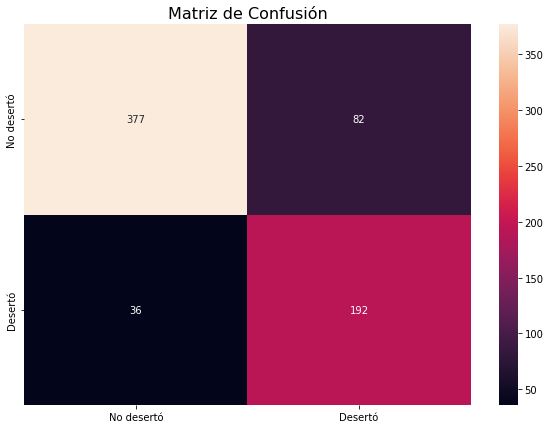

In [374]:
## Calculamos e imprimimos la Matriz de Confusión.
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = ['No desertó', 'Desertó'], columns = ['No desertó', "Desertó"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt='g')
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

#**Pruebo otro modelo**

## **MODELO II** - lr = 0.001

In [357]:
# Para eliminar los modelos que hayan quedado guardados en memoria
tf.keras.backend.clear_session() 

modelII = Sequential([
  # Primera capa de la red
  Dense(16,input_dim=28, activation='relu'),
  # Hidden Layer
  Dense(16, activation='sigmoid'),
  # Salida de la red
  Dense(1, activation='sigmoid')
])

In [358]:
# Veamos la arquitectura de nuestro modelo
modelII.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


## **Optimizador & Función de Penalizaci+on**

In [359]:
# Optimizador
lrII = 0.001
optII = tf.keras.optimizers.Adam(learning_rate = lrII)
# Funcion de penalizacion Error Cuadrático Medio
loss_funcII = tf.keras.losses.MeanSquaredError()

## **COMPILACIÓN DEL MODELO DE REDES NEURONALES**

In [360]:
# Hasta este momento, hemos definido los elementos que conformaran el modelo.
# [arquitectura, optimizer, loss function].
# Internamente, estuvimos armando un 'grafo computacional', el cual debe compilarse.
modelII.compile(optimizer = optII,
              loss = loss_funcII,
              metrics = ['accuracy'])

## **ENTRENAMIENTO**

In [361]:
# Batch Size
bsII = 100
# Epochs de entrenamiento
epochs_trainingII = 500
# Entrenamos!
trainingII = modelII.fit(x_train_norm,ytrain_over, epochs=epochs_trainingII, validation_split=0.2, batch_size=bsII)

Epoch 1/500
25/25 [==============================] - 2s 16ms/step - loss: 0.3005 - accuracy: 0.6060 - val_loss: 0.6172 - val_accuracy: 0.0760
Epoch 2/500
25/25 [==============================] - 0s 4ms/step - loss: 0.2704 - accuracy: 0.6064 - val_loss: 0.5303 - val_accuracy: 0.0760
Epoch 3/500
25/25 [==============================] - 0s 4ms/step - loss: 0.2445 - accuracy: 0.6089 - val_loss: 0.4076 - val_accuracy: 0.1289
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.2165 - accuracy: 0.6556 - val_loss: 0.2609 - val_accuracy: 0.4744
Epoch 5/500
25/25 [==============================] - 0s 4ms/step - loss: 0.1865 - accuracy: 0.7606 - val_loss: 0.2293 - val_accuracy: 0.6033
Epoch 6/500
25/25 [==============================] - 0s 4ms/step - loss: 0.1672 - accuracy: 0.7888 - val_loss: 0.2147 - val_accuracy: 0.6413
Epoch 7/500
25/25 [==============================] - 0s 4ms/step - loss: 0.1543 - accuracy: 0.8086 - val_loss: 0.1984 - val_accuracy: 0.6744
Epoch 8/500


## **HISTORIAL**

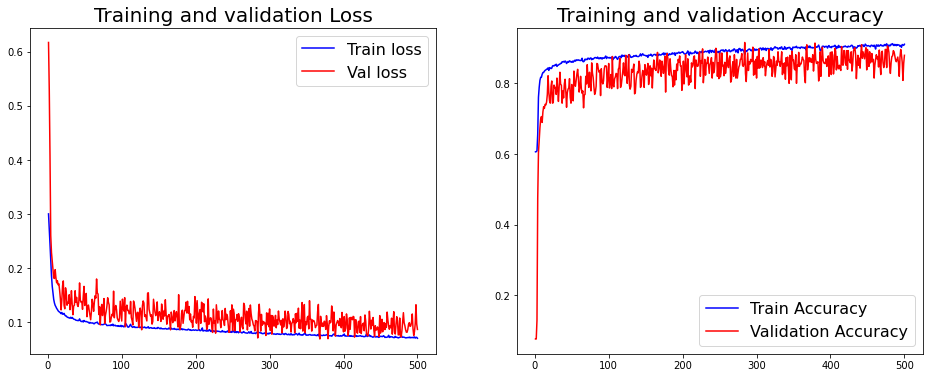

In [362]:
# El historial de entrenamiento quedó guardado en 
# 'history.history', ingresamos como 'key' cada una de las metricas que queremos plotear.

#Loss
loss_historyII = trainingII.history['loss']
val_loss_histII = trainingII.history['val_loss']

#Accuracy
train_acc_historyII = trainingII.history['accuracy']
val_acc_histII = trainingII.history['val_accuracy']
epochsII = range(1, len(loss_historyII) + 1)

fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(epochsII, loss_historyII, 'b', label='Train loss')
axs[0].plot(epochsII, val_loss_histII, 'r', label='Val loss')
axs[0].set_title('Training and validation Loss',fontsize=20)
axs[0].legend(fontsize=16)
axs[1].plot(epochsII, train_acc_historyII, 'b', label='Train Accuracy')
axs[1].plot(epochsII, val_acc_histII, 'r', label='Validation Accuracy')
axs[1].set_title('Training and validation Accuracy',fontsize=20)
axs[1].legend(fontsize=16)
plt.show()

## **EVALUACIÓN**

In [363]:
## Evaluamos el modelo.
modelII.evaluate(x_test_norm, y_test,verbose=2)

22/22 - 1s - loss: 0.1373 - accuracy: 0.8180 - 627ms/epoch - 28ms/step


[0.13727863132953644, 0.8180494904518127]

## **MATRIZ DE CONFUSIÓN**

In [364]:
y_hatII = modelII.predict(x_test_norm) # Salida de la red
y_predII = np.round(y_hatII, 0)

22/22 [==============================] - 0s 1ms/step


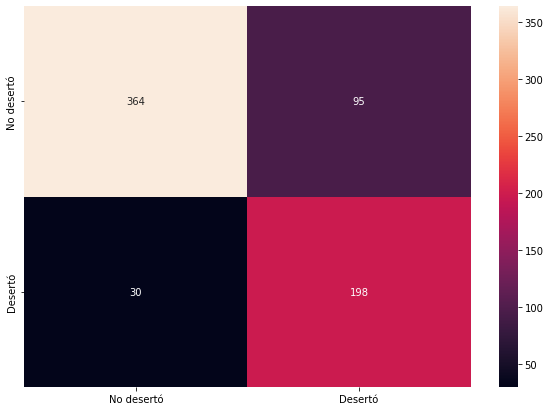

In [365]:
## Calculamos e imprimimos la Matriz de Confusión.
cmII = confusion_matrix(y_test, y_predII)

df_cmII = pd.DataFrame(cmII, index = ['No desertó', 'Desertó'], columns = ['No desertó', "Desertó"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cmII, annot=True,fmt='g')

plt.show()

#**Pruebo otro modelo**

## **MODELO III** lr = 0.001   batch = 150

In [339]:
# Para eliminar los modelos que hayan quedado guardados en memoria
tf.keras.backend.clear_session() 

modelII = Sequential([
  # Primera capa de la red
  Dense(16,input_dim=28, activation='sigmoid'),
  # Hidden Layer
  Dense(16, activation='sigmoid'),
  # Salida de la red
  Dense(1, activation='sigmoid')
])

## **Optimizador & Función de Penalizaci+on**

In [340]:
# definimos los hiperparametros de entrenamiento de la NN
# l2_reg = 0.01  # regresion de Ridge, a las variables menos importantes le aplico un peso muy pequeño (NO igual a 0, esa es la otra regresión)
# lrate = 0.001  # learning rate
# epochs = 50  # epocas, ciclos de aprensdizaje que voy a realizar
# bachs = 8   # cantidad de datos por ciclo

################### Optimizer ################### 
# optim = tf.keras.optimizers.Adam(learning_rate= lrate)
# --> Adam = algoritmo más pro del gradiente desendiente. Si tengo una pendiente muy pronunciada doy pasos más grandes, adapto el 
# learning rate en función del cuan pronunciada es la caida.

In [341]:
# Optimizador
lrII = 0.001
optII = tf.keras.optimizers.Adam(learning_rate = lrII)
# Funcion de penalizacion Error Cuadrático Medio
loss_funcII = tf.keras.losses.MeanSquaredError()

## **COMPILACIÓN DEL MODELO DE REDES NEURONALES**

In [342]:
# Hasta este momento, hemos definido los elementos que conformaran el modelo.
# [arquitectura, optimizer, loss function].
# Internamente, estuvimos armando un 'grafo computacional', el cual debe compilarse.
modelII.compile(optimizer = optII,
              loss = loss_funcII,
              metrics = ['accuracy'])

## **ENTRENAMIENTO**

In [343]:
# Batch Size
bsII = 150
# Epochs de entrenamiento
epochs_trainingII = 500
# Entrenamos!
trainingII = modelII.fit(x_train_norm,ytrain_over, epochs=epochs_trainingII, validation_split=0.2,batch_size=bsII)

Epoch 1/500
17/17 [==============================] - 2s 22ms/step - loss: 0.2540 - accuracy: 0.4655 - val_loss: 0.2700 - val_accuracy: 0.1587
Epoch 2/500
17/17 [==============================] - 0s 7ms/step - loss: 0.2385 - accuracy: 0.6110 - val_loss: 0.3229 - val_accuracy: 0.0793
Epoch 3/500
17/17 [==============================] - 0s 5ms/step - loss: 0.2330 - accuracy: 0.6064 - val_loss: 0.3371 - val_accuracy: 0.0793
Epoch 4/500
17/17 [==============================] - 0s 5ms/step - loss: 0.2283 - accuracy: 0.6089 - val_loss: 0.3237 - val_accuracy: 0.1074
Epoch 5/500
17/17 [==============================] - 0s 5ms/step - loss: 0.2211 - accuracy: 0.6383 - val_loss: 0.3003 - val_accuracy: 0.1983
Epoch 6/500
17/17 [==============================] - 0s 4ms/step - loss: 0.2115 - accuracy: 0.6664 - val_loss: 0.2948 - val_accuracy: 0.2711
Epoch 7/500
17/17 [==============================] - 0s 6ms/step - loss: 0.2029 - accuracy: 0.6912 - val_loss: 0.2848 - val_accuracy: 0.3471
Epoch 8/500


## **HISTORIAL**

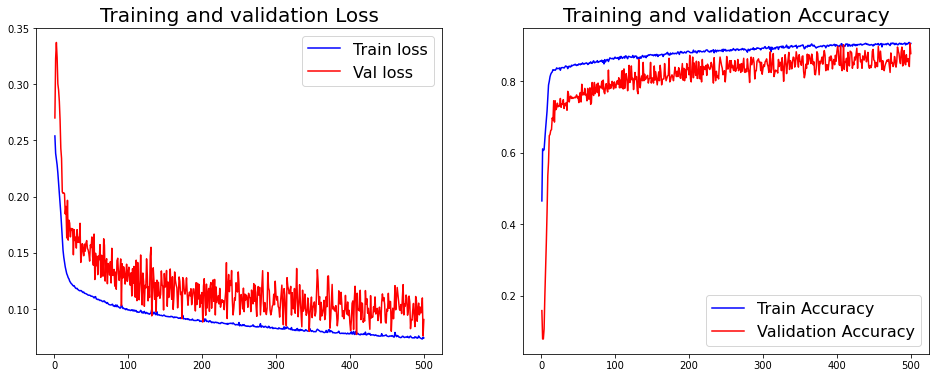

In [344]:
# El historial de entrenamiento quedó guardado en 
# 'history.history', ingresamos como 'key' cada una de las metricas que queremos plotear.

#Loss
loss_historyII = trainingII.history['loss']
val_loss_histII = trainingII.history['val_loss']

#Accuracy
train_acc_historyII = trainingII.history['accuracy']
val_acc_histII = trainingII.history['val_accuracy']
epochsII = range(1, len(loss_historyII) + 1)

fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(epochsII, loss_historyII, 'b', label='Train loss')
axs[0].plot(epochsII, val_loss_histII, 'r', label='Val loss')
axs[0].set_title('Training and validation Loss',fontsize=20)
axs[0].legend(fontsize=16)
axs[1].plot(epochsII, train_acc_historyII, 'b', label='Train Accuracy')
axs[1].plot(epochsII, val_acc_histII, 'r', label='Validation Accuracy')
axs[1].set_title('Training and validation Accuracy',fontsize=20)
axs[1].legend(fontsize=16)
plt.show()

## **EVALUACIÓN**

In [345]:
## Evaluamos el modelo.
modelII.evaluate(x_test_norm, y_test,verbose=2)

22/22 - 1s - loss: 0.1470 - accuracy: 0.7875 - 646ms/epoch - 29ms/step


[0.14699295163154602, 0.7874817848205566]

## **MATRIZ DE CONFUSIÓN**

In [346]:
y_hatII = modelII.predict(x_test_norm) # Salida de la red
y_predII = np.round(y_hatII, 0)

22/22 [==============================] - 0s 2ms/step


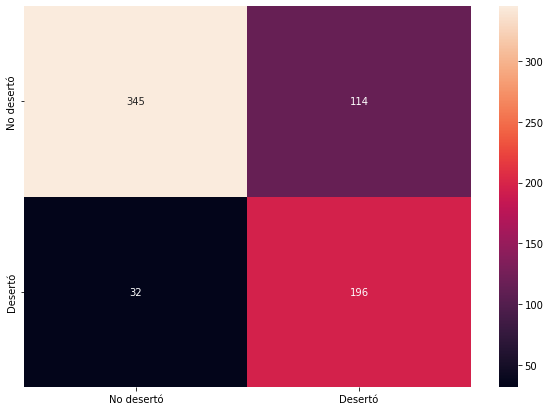

In [347]:
## Calculamos e imprimimos la Matriz de Confusión.
cmII = confusion_matrix(y_test, y_predII)

df_cmII = pd.DataFrame(cmII, index = ['No desertó', 'Desertó'], columns = ['No desertó', "Desertó"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cmII, annot=True,fmt='g')

plt.show()